In [83]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco
import itertools as it
import datetime

In [85]:
#Configuration
quandl.ApiConfig.api_key = "" #Enter your free Quandl API Key

In [77]:
tickers = ['MMM', 'AAPL', 'PFE', 'MSFT', 'BA']

In [78]:
def get_combination(list_):
    comb = []
    for r in range(2, len(list_) + 1):
        comb += (list(it.combinations(list_, r)))
    return [list(i) for i in comb]

def get_annualized_portfolio_performance(weights, mean_returns, cov_matrix):
    expected_returns = np.sum(weights*mean_returns) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, expected_returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = get_annualized_portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #fun says that the sum of x should be equal to 1.
    bound = (0.0,1.0) #range of 0 to 1.
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return get_annualized_portfolio_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def return_best_portfolio_options(tickers, risk_free_rate=0.0178):
    quandl_list = ['EOD/{}'.format(i) for i in tickers]
    start_date = (datetime.datetime.now()- datetime.timedelta(days=365)).strftime('%Y-%m-%d')
    try:
        data = quandl.get(quandl_list, column_index = 11, start_date=start_date)
    except:
        print("Please provide a valid Quandl API Key. You can get it for free: https://docs.quandl.com/docs#section-authentication")
        return
    data.columns = tickers
    data.dropna(axis=1, how='all', inplace=True)
    combinations = get_combination(data.columns)
    summary = pd.DataFrame(columns=['Combination','Max Sharpe Return','Max Sharpe Risk','Max Sharpe Weights','Min Variance Return','Min Variance Risk','Min Variance Weights'])
    for n,c in enumerate(combinations):
        temp_data = data[c]
        returns = temp_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        
        max_sharpe = max_sharpe_ratio(cov_matrix=cov_matrix, mean_returns=mean_returns, risk_free_rate=risk_free_rate)
        max_sharpe_weights = {col:round(i*100,2) for i, col in zip(max_sharpe.x, c)}
        max_sharpe_details = get_annualized_portfolio_performance(cov_matrix=cov_matrix, mean_returns=mean_returns, weights=max_sharpe.x)
        
        min_var = min_variance(mean_returns=mean_returns, cov_matrix=cov_matrix)
        min_variance_weights = {col:round(i*100,2) for i, col in zip(min_var.x, c)}
        min_variance_details = get_annualized_portfolio_performance(cov_matrix=cov_matrix, mean_returns=mean_returns, weights=min_var.x)
        
        index = ','.join(c)
        summary.loc[n] = [index,max_sharpe_details[1],max_sharpe_details[0],max_sharpe_weights,min_variance_details[1],min_variance_details[0], min_variance_weights]
        
    summary.set_index(['Combination'], inplace=True)
    return summary

def reorganize_data(data):
    maxsharpe = data.copy()[['Max Sharpe Return', 'Max Sharpe Risk']]
    maxsharpe['Metric'] = 'Max Sharpe'
    maxsharpe.columns = ['Return','Risk','Metric']
    minvol = dat.copy()[['Min Variance Return', 'Min Variance Risk']]
    minvol['Metric'] = 'Min Variance'
    minvol.columns = ['Return','Risk','Metric']
    result = pd.concat([maxsharpe, minvol])
    result = result.set_index('Metric', append=True)
    return result

In [79]:
dat = return_best_portfolio_options(tickers)

In [80]:
org = reorganize_data(dat)
org.head()

,,Return,Risk
Combination,Metric,,
"MMM,AAPL",Max Sharpe,0.190867,0.243018
"MMM,PFE",Max Sharpe,0.262199,0.178207
"MMM,MSFT",Max Sharpe,0.291143,0.249165
"MMM,BA",Max Sharpe,0.376069,0.278228
"AAPL,PFE",Max Sharpe,0.254403,0.170733


Text(0,0.5,'Portfolio Return')

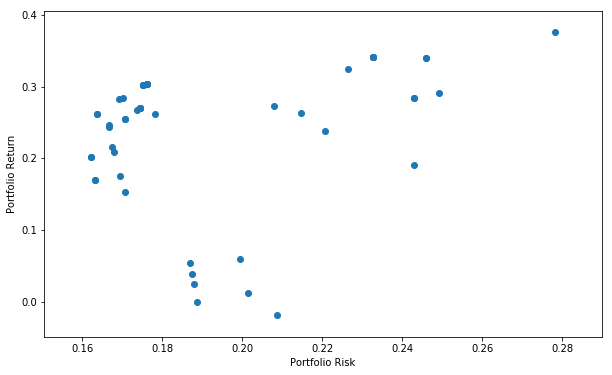

In [81]:
plt.figure(figsize=(10,6))
plt.scatter(x=org.Risk, y=org.Return)
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')

In [82]:
dat.sort_values(by='Max Sharpe Risk', ascending=False)

,Max Sharpe Return,Max Sharpe Risk,Max Sharpe Weights,Min Variance Return,Min Variance Risk,Min Variance Weights
Combination,,,,,,
"MMM,BA",0.376069,0.278228,"{'MMM': 0.0, 'BA': 100.0}",-0.019119,0.208752,"{'MMM': 78.34, 'BA': 21.66}"
"MMM,MSFT",0.291143,0.249165,"{'MMM': 0.0, 'MSFT': 100.0}",0.012559,0.201541,"{'MMM': 66.4, 'MSFT': 33.6}"
"MMM,AAPL,BA",0.339680,0.245909,"{'MMM': 0.0, 'AAPL': 19.65, 'BA': 80.35}",0.038443,0.187482,"{'MMM': 53.13, 'AAPL': 37.59, 'BA': 9.28}"
"AAPL,BA",0.339631,0.245871,"{'AAPL': 19.67, 'BA': 80.33}",0.263342,0.214764,"{'AAPL': 60.87, 'BA': 39.13}"
"MMM,AAPL",0.190867,0.243018,"{'MMM': 0.0, 'AAPL': 100.0}",-0.000184,0.188635,"{'MMM': 59.84, 'AAPL': 40.16}"
"AAPL,MSFT",0.284615,0.242892,"{'AAPL': 6.51, 'MSFT': 93.49}",0.237810,0.220570,"{'AAPL': 53.19, 'MSFT': 46.81}"
"MMM,AAPL,MSFT",0.284523,0.242808,"{'MMM': 0.0, 'AAPL': 6.6, 'MSFT': 93.4}",0.024203,0.187875,"{'MMM': 55.18, 'AAPL': 35.33, 'MSFT': 9.49}"
"MMM,AAPL,MSFT,BA",0.341509,0.232755,"{'MMM': 0.0, 'AAPL': 0.0, 'MSFT': 40.69, 'BA':...",0.053249,0.187015,"{'MMM': 50.25, 'AAPL': 33.93, 'MSFT': 7.65, 'B..."
"AAPL,MSFT,BA",0.341508,0.232754,"{'AAPL': 0.0, 'MSFT': 40.7, 'BA': 59.3}",0.272303,0.207989,"{'AAPL': 43.17, 'MSFT': 28.04, 'BA': 28.79}"
